In [2]:
import pandas as pd
import subprocess
import os
from collections import Counter
import sys
from py2cfg import CFGBuilder

In [3]:
df= pd.read_csv(r'geocoder_results\commits_info.csv')
files = df['new_file_path'].dropna().tolist()
file_counts = Counter(files)
top5 = file_counts.most_common(5)
print("Top 5 frequently changed source code files:")
for filename, count in top5:
    print(f"{filename}: {count} changes")

most_frequent_py = None
for filename, count in file_counts.most_common():
    if filename.endswith('.py') and not filename.endswith('init__.py') and not filename.endswith('api.py'):
        most_frequent_py = filename
        break
if not most_frequent_py:
    print("No Python file found among the frequently changed files.")
    sys.exit(0)
print(f"\nMost frequently changed Python file: {most_frequent_py}")

df_py = df[df['new_file_path'] == most_frequent_py].copy()
df_py.sort_index(inplace=True) 
df_py.head(5)

Top 5 frequently changed source code files:
__init__.py: 72 changes
api.py: 61 changes
README.md: 59 changes
base.py: 43 changes
google.py: 41 changes

Most frequently changed Python file: base.py


,old_file_path,new_file_path,commit_SHA,parent_commit_SHA,commit_message,diff_histogram,old_file_MCC,new_file_MCC
13,geocoder/base.py,base.py,91d02570e4a60c0d9abd8668d9b16e61ee84d8e0,4c8d797aabb838dc68bbc0d0e67fa23c1587ef1f,Unicode Errors #171\n- Fixed __repr__ unicode ...,NaN,80.0,80.0
19,geocoder/base.py,base.py,8ebf4c0c9e931aeebb7e2a513399ec9db36fea44,0ba0f25857b870c88633d38e1267ae413ee92cf8,Can't decode string in Py3 #171\n- Remove enco...,NaN,80.0,80.0
21,geocoder/base.py,base.py,ff9e9e178eaec3b40b1c0f9e8659750add73d892,8ebf4c0c9e931aeebb7e2a513399ec9db36fea44,Remove System Exit #172,NaN,80.0,80.0
22,geocoder/base.py,base.py,cf0fc93c7c4b661bb6fb41d0f9837a7198daf3ed,ff9e9e178eaec3b40b1c0f9e8659750add73d892,Exception must be last,NaN,80.0,80.0
27,geocoder/base.py,base.py,38e274bd1e01c4eb59abafe5908a3de52bf02d4d,a303c7e3d7a9c8ce703f0da9205f155a8ff1d3be,"Modified bbox for GeoJSON #168\n- bbox= west, ...",NaN,80.0,80.0


In [4]:
def get_file_source_at_commit(repo_path, commit_hash, file_path):
    """ Get the source code of the file at a specific commit. """
    cmd = ["git", "show", f"{commit_hash}:{file_path}"]
    result = subprocess.run(cmd, cwd=repo_path, capture_output=True, text=True)
    return result.stdout if result.returncode == 0 else None

def extract_source_and_update_df(repo_path, df):
    """ Extract source code for each commit and update DataFrame. """
    df["source_code"] = df.apply(lambda row: get_file_source_at_commit(repo_path, row["commit_SHA"], row["old_file_path"]), axis=1)
    return df
    
df_py = extract_source_and_update_df('geocoder', df_py)

In [5]:
df_py.head()

,old_file_path,new_file_path,commit_SHA,parent_commit_SHA,commit_message,diff_histogram,old_file_MCC,new_file_MCC,source_code
13,geocoder/base.py,base.py,91d02570e4a60c0d9abd8668d9b16e61ee84d8e0,4c8d797aabb838dc68bbc0d0e67fa23c1587ef1f,Unicode Errors #171\n- Fixed __repr__ unicode ...,NaN,80.0,80.0,#!/usr/bin/python\n# coding: utf8\n\nfrom __fu...
19,geocoder/base.py,base.py,8ebf4c0c9e931aeebb7e2a513399ec9db36fea44,0ba0f25857b870c88633d38e1267ae413ee92cf8,Can't decode string in Py3 #171\n- Remove enco...,NaN,80.0,80.0,#!/usr/bin/python\n# coding: utf8\n\nfrom __fu...
21,geocoder/base.py,base.py,ff9e9e178eaec3b40b1c0f9e8659750add73d892,8ebf4c0c9e931aeebb7e2a513399ec9db36fea44,Remove System Exit #172,NaN,80.0,80.0,#!/usr/bin/python\n# coding: utf8\n\nfrom __fu...
22,geocoder/base.py,base.py,cf0fc93c7c4b661bb6fb41d0f9837a7198daf3ed,ff9e9e178eaec3b40b1c0f9e8659750add73d892,Exception must be last,NaN,80.0,80.0,#!/usr/bin/python\n# coding: utf8\n\nfrom __fu...
27,geocoder/base.py,base.py,38e274bd1e01c4eb59abafe5908a3de52bf02d4d,a303c7e3d7a9c8ce703f0da9205f155a8ff1d3be,"Modified bbox for GeoJSON #168\n- bbox= west, ...",NaN,80.0,80.0,#!/usr/bin/python\n# coding: utf8\n\nfrom __fu...


In [5]:
def generate_cfg_py2cfg(source_code, file_name, commit_sha, output_dir):
    if not source_code:
        print(f"Skipping commit {commit_sha} as source code is empty or None")
        return

    try:
        cfg = CFGBuilder().build_from_src(file_name, source_code)
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"cfg_{commit_sha}.png")
        cfg.build_visual(output_path, format='png', cleanup=True)
        print(f"Saved CFG for {commit_sha} at {output_path}")

    except ValueError as e:
        print(f"Error generating CFG for commit {commit_sha}: {e}")

In [6]:
def process_dataframe_and_generate_cfg(df, output_dir):
    """Iterates over DataFrame and generates CFGs for each commit."""
    for _, row in df.iterrows():
        commit_sha = row["commit_SHA"]
        file_name = os.path.basename(row["old_file_path"])  
        source_code = row["source_code"]

        generate_cfg_py2cfg(source_code, file_name, commit_sha, output_dir)
    print(f"All cfgs saved to {output_dir}")

output_directory = "cfg_outputs" 
process_dataframe_and_generate_cfg(df_py, output_directory)


(process:13176): Pango-WARNING **: 00:48:33.621: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


Saved CFG for 91d02570e4a60c0d9abd8668d9b16e61ee84d8e0 at cfg_outputs\cfg_91d02570e4a60c0d9abd8668d9b16e61ee84d8e0.png



(process:22864): Pango-WARNING **: 00:48:45.408: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


Saved CFG for 8ebf4c0c9e931aeebb7e2a513399ec9db36fea44 at cfg_outputs\cfg_8ebf4c0c9e931aeebb7e2a513399ec9db36fea44.png
Error generating CFG for commit ff9e9e178eaec3b40b1c0f9e8659750add73d892: Unexpected object None
Error generating CFG for commit cf0fc93c7c4b661bb6fb41d0f9837a7198daf3ed: Unexpected object None
Error generating CFG for commit 38e274bd1e01c4eb59abafe5908a3de52bf02d4d: Unexpected object None
Error generating CFG for commit 9741652778bdfbbbd974b85a69d11724678dffc1: Unexpected object None
Error generating CFG for commit c77f6a5ff1f4bab6c256d510b0dcb16f76a09be7: Unexpected object None
Error generating CFG for commit 92c31cbb48f8dea7404cdf835fdf1c399ac77210: Unexpected object None
Error generating CFG for commit 7080fd736c41a476d4e8c0b7a24c9356d397de4e: Unexpected object None
Error generating CFG for commit 7671502e13f6d225ac371d54e778f416497bb0ab: Unexpected object None
Error generating CFG for commit c754db2ff4825c696c585a391b4ee8bf49ee95a0: Unexpected object None
Error ge

c:\Python312\Lib\site-packages\py2cfg\model.py:347: SyntaxWarning: invalid escape sequence '\l'
  text = "\l".join(line for line in block.get_source().splitlines())
c:\Python312\Lib\site-packages\py2cfg\model.py:440: SyntaxWarning: invalid escape sequence '\l'
  original_nodelabel = original_nodelabel.replace("\l", "\n")
c:\Python312\Lib\site-packages\py2cfg\model.py:443: SyntaxWarning: invalid escape sequence '\l'
  nodelabel += tmp_line + "\l"
c:\Python312\Lib\site-packages\py2cfg\model.py:518: SyntaxWarning: invalid escape sequence '\l'
  line += "\l"


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


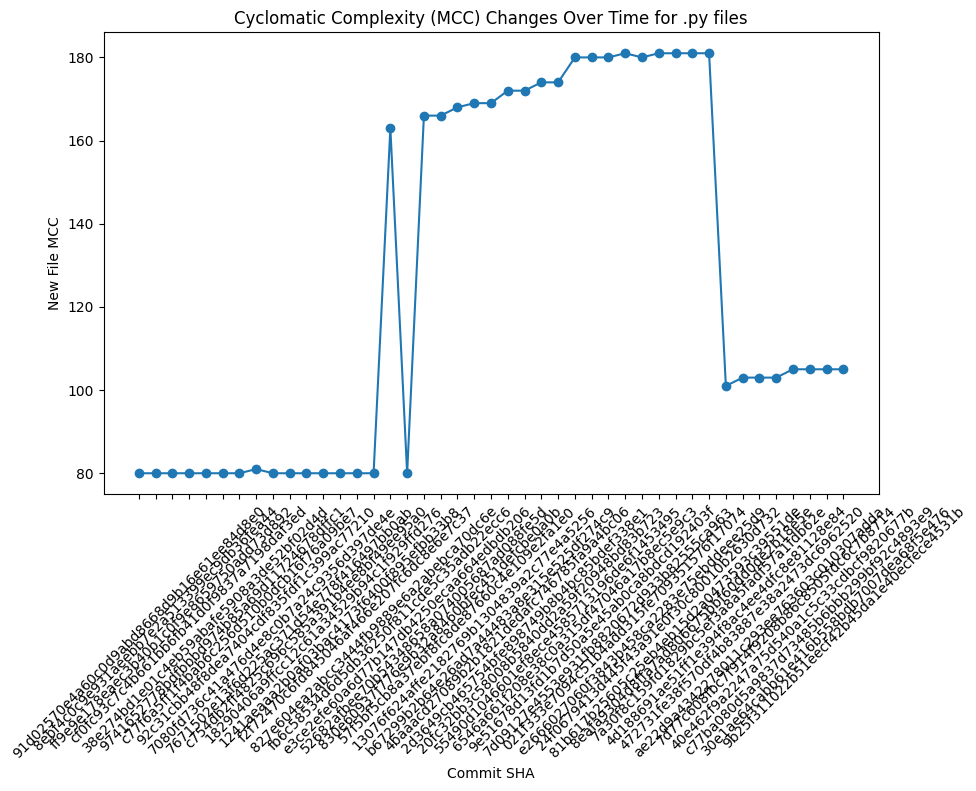

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


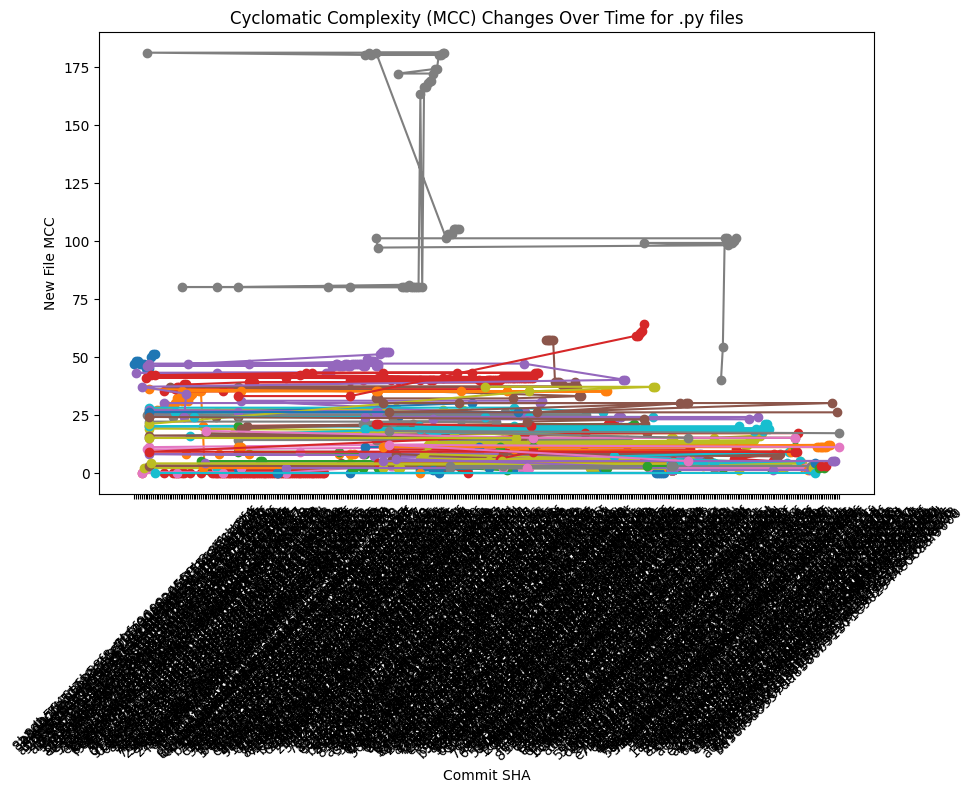

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = pd.read_csv(r'geocoder_results\commits_info.csv')
df_py_file = df[df['new_file_path'].str.endswith('.py')]
def plot_mcc(df):
    unique_files = df['new_file_path'].unique()
    colors = list(mcolors.TABLEAU_COLORS.values()) 

    plt.figure(figsize=(10, 6))
    for i, file in enumerate(unique_files):
        file_df = df[df['new_file_path'] == file]
        plt.plot(file_df['commit_SHA'], file_df['new_file_MCC'], color=colors[i % len(colors)], marker='o', label=None)

    plt.xlabel('Commit SHA')
    plt.ylabel('New File MCC')
    plt.legend().set_visible(False)
    plt.title('Cyclomatic Complexity (MCC) Changes Over Time for .py files')
    plt.xticks(rotation=45)
    plt.show()

plot_mcc(df_py)
plot_mcc(df_py_file)

